# Dynamic Pricing Model Training & Evaluation

This notebook systematically trains and compares multiple machine learning models for Airbnb rental price prediction. We evaluate **GradientBoosting**, **XGBoost**, and **Random Forest** regressors to identify the champion model that delivers the best 8–15% yield optimization for hosts.

**Workflow:**
1. Load clean dataset and perform train/test split
2. Engineer model-ready features (encoding, scaling)
3. Train 3 candidate models with hyperparameter tuning
4. Compare performance using MAE, RMSE, R², and cross-validation
5. Analyze feature importance and residuals
6. Select and serialize the best model for deployment


## 1. Load Dataset & Exploratory Setup

We import the curated `all_listings_clean.csv`, inspect data quality, and prepare the modeling environment with all necessary libraries.


In [1]:
from __future__ import annotations

import pickle
import warnings
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

try:
    import xgboost as xgb
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    warnings.warn("XGBoost not installed. Install with: pip install xgboost")

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use("seaborn-v0_8")
sns.set_theme(style="whitegrid", palette="muted")

ROOT = Path("/home/medgm/vsc/dApp-Ai")
DATA_PATH = ROOT / "data" / "used_or_will_be_used" / "all_listings_clean.csv"
MODEL_DIR = ROOT / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

df_raw = pd.read_csv(DATA_PATH)
print(f"✓ Loaded {len(df_raw):,} listings from {DATA_PATH.name}")
print(f"✓ Columns: {len(df_raw.columns)}")
print(f"✓ Target variable: nightly_price")
df_raw.head(3)


✓ Loaded 1,656 listings from all_listings_clean.csv
✓ Columns: 34
✓ Target variable: nightly_price


,room_id,listing_name,title,city,season,start_date,end_date,stay_length_nights,nightly_price,total_price,...,badge_count,source_file,days_until_checkin,review_density,badge_premium_indicator,has_discount,season_category,within_30_days,within_90_days,quality_proxy
0,1139986052055387191,Boho in Agadir with pool | fiber optic,Apartment in Agadir,agadir,april,2025-04-15,2025-04-20,5.0,429.2,2146.0,...,1,data/raw/april/agadir_2025-04-15_2025-04-20.json,-221,14.4,1,1,april,0,0,3
1,1423339758993017247,City center appartement with Hamam,Apartment in Agadir,agadir,april,2025-04-15,2025-04-20,5.0,496.0,2480.0,...,1,data/raw/april/agadir_2025-04-15_2025-04-20.json,-221,5.2,1,1,april,0,0,3
2,1382067150050662474,Luxe et Confort - Vue Spectaculaire sur la Ville,Apartment in Agadir,agadir,april,2025-04-15,2025-04-20,5.0,464.0,2320.0,...,1,data/raw/april/agadir_2025-04-15_2025-04-20.json,-221,6.4,1,0,april,0,0,3


## 2. Feature Engineering & Train/Test Split

We select modeling features, separate numeric vs. categorical columns, and split into training (80%) and testing (20%) sets while preserving the target distribution.


In [2]:
# Define modeling features
numeric_features = [
    "stay_length_nights",
    "discount_rate",
    "bedroom_count",
    "bed_count",
    "rating_value",
    "rating_count",
    "image_count",
    "badge_count",
    "review_density",
    "quality_proxy",
]

categorical_features = [
    "city",
    "season_category",
]

target_col = "nightly_price"

# Prepare feature matrix
df_model = df_raw.dropna(subset=[target_col]).copy()

# Fill missing numerics with median, categoricals with mode
for col in numeric_features:
    if col in df_model.columns:
        df_model[col] = df_model[col].fillna(df_model[col].median())

for col in categorical_features:
    if col in df_model.columns:
        df_model[col] = df_model[col].fillna(df_model[col].mode()[0] if not df_model[col].mode().empty else "unknown")

# Filter to only available features
numeric_features = [f for f in numeric_features if f in df_model.columns]
categorical_features = [f for f in categorical_features if f in df_model.columns]
all_features = numeric_features + categorical_features

X = df_model[all_features]
y = df_model[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

print(f"✓ Feature set: {len(all_features)} features")
print(f"  - Numeric: {numeric_features}")
print(f"  - Categorical: {categorical_features}")
print(f"\n✓ Train set: {len(X_train):,} samples")
print(f"✓ Test set:  {len(X_test):,} samples")
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")


✓ Feature set: 12 features
  - Numeric: ['stay_length_nights', 'discount_rate', 'bedroom_count', 'bed_count', 'rating_value', 'rating_count', 'image_count', 'badge_count', 'review_density', 'quality_proxy']
  - Categorical: ['city', 'season_category']

✓ Train set: 1,324 samples
✓ Test set:  332 samples

Target distribution:
  Train - Mean: 408.20, Std: 108.16
  Test  - Mean: 410.54, Std: 107.16


## 3. Build Preprocessing Pipeline

We construct a scikit-learn pipeline that standardizes numeric features and one-hot encodes categoricals, ensuring consistent transformations across train/test/production.


In [3]:
# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

print("✓ Preprocessing pipeline created:")
print(f"  - Numeric features: StandardScaler")
print(f"  - Categorical features: OneHotEncoder (ignore unknown)")
print(f"\n✓ Pipeline ready for model integration")


✓ Preprocessing pipeline created:
  - Numeric features: StandardScaler
  - Categorical features: OneHotEncoder (ignore unknown)

✓ Pipeline ready for model integration


## 4. Train & Tune Candidate Models

We train three regressors with GridSearchCV to find optimal hyperparameters:
- **GradientBoostingRegressor** (scikit-learn)
- **XGBoost** (gradient boosting with regularization)
- **RandomForestRegressor** (ensemble of decision trees)

Each model is evaluated using 5-fold cross-validation on the training set.


In [4]:
# Model 1: GradientBoostingRegressor
print("=" * 70)
print("MODEL 1: GradientBoostingRegressor")
print("=" * 70)

gb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=RANDOM_STATE))
])

gb_param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__learning_rate": [0.05, 0.1],
    "regressor__max_depth": [3, 5],
    "regressor__subsample": [0.8, 1.0],
}

gb_grid = GridSearchCV(
    gb_pipeline,
    gb_param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)

print("Training with GridSearchCV (5-fold CV)...")
gb_grid.fit(X_train, y_train)

print(f"\n✓ Best parameters: {gb_grid.best_params_}")
print(f"✓ Best CV MAE: {-gb_grid.best_score_:.2f}")

best_gb = gb_grid.best_estimator_
y_pred_gb_train = best_gb.predict(X_train)
y_pred_gb_test = best_gb.predict(X_test)

mae_gb_train = mean_absolute_error(y_train, y_pred_gb_train)
mae_gb_test = mean_absolute_error(y_test, y_pred_gb_test)
rmse_gb_test = np.sqrt(mean_squared_error(y_test, y_pred_gb_test))
r2_gb_test = r2_score(y_test, y_pred_gb_test)

print(f"\n📊 GradientBoosting Performance:")
print(f"  Train MAE: {mae_gb_train:.2f}")
print(f"  Test MAE:  {mae_gb_test:.2f}")
print(f"  Test RMSE: {rmse_gb_test:.2f}")
print(f"  Test R²:   {r2_gb_test:.4f}")


MODEL 1: GradientBoostingRegressor
Training with GridSearchCV (5-fold CV)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

✓ Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 1.0}
✓ Best CV MAE: 57.89

📊 GradientBoosting Performance:
  Train MAE: 51.07
  Test MAE:  56.32
  Test RMSE: 72.03
  Test R²:   0.5468

✓ Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 1.0}
✓ Best CV MAE: 57.89

📊 GradientBoosting Performance:
  Train MAE: 51.07
  Test MAE:  56.32
  Test RMSE: 72.03
  Test R²:   0.5468


In [5]:
# Model 2: XGBoost
print("\n" + "=" * 70)
print("MODEL 2: XGBoost")
print("=" * 70)

if HAS_XGBOOST:
    xgb_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", xgb.XGBRegressor(random_state=RANDOM_STATE, objective="reg:squarederror"))
    ])

    xgb_param_grid = {
        "regressor__n_estimators": [100, 200],
        "regressor__learning_rate": [0.05, 0.1],
        "regressor__max_depth": [3, 5],
        "regressor__subsample": [0.8, 1.0],
        "regressor__colsample_bytree": [0.8, 1.0],
    }

    xgb_grid = GridSearchCV(
        xgb_pipeline,
        xgb_param_grid,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        verbose=1,
    )

    print("Training with GridSearchCV (5-fold CV)...")
    xgb_grid.fit(X_train, y_train)

    print(f"\n✓ Best parameters: {xgb_grid.best_params_}")
    print(f"✓ Best CV MAE: {-xgb_grid.best_score_:.2f}")

    best_xgb = xgb_grid.best_estimator_
    y_pred_xgb_train = best_xgb.predict(X_train)
    y_pred_xgb_test = best_xgb.predict(X_test)

    mae_xgb_train = mean_absolute_error(y_train, y_pred_xgb_train)
    mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb_test)
    rmse_xgb_test = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
    r2_xgb_test = r2_score(y_test, y_pred_xgb_test)

    print(f"\n📊 XGBoost Performance:")
    print(f"  Train MAE: {mae_xgb_train:.2f}")
    print(f"  Test MAE:  {mae_xgb_test:.2f}")
    print(f"  Test RMSE: {rmse_xgb_test:.2f}")
    print(f"  Test R²:   {r2_xgb_test:.4f}")
else:
    print("⚠️  XGBoost not installed. Skipping this model.")
    print("   Install with: pip install xgboost")
    best_xgb = None
    mae_xgb_test = np.inf
    rmse_xgb_test = np.inf
    r2_xgb_test = -np.inf



MODEL 2: XGBoost
Training with GridSearchCV (5-fold CV)...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

✓ Best parameters: {'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 200, 'regressor__subsample': 1.0}
✓ Best CV MAE: 57.71

📊 XGBoost Performance:
  Train MAE: 52.09
  Test MAE:  56.01
  Test RMSE: 71.33
  Test R²:   0.5556

✓ Best parameters: {'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 200, 'regressor__subsample': 1.0}
✓ Best CV MAE: 57.71

📊 XGBoost Performance:
  Train MAE: 52.09
  Test MAE:  56.01
  Test RMSE: 71.33
  Test R²:   0.5556


In [6]:
# Model 3: RandomForestRegressor
print("\n" + "=" * 70)
print("MODEL 3: RandomForestRegressor")
print("=" * 70)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=RANDOM_STATE))
])

rf_param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [10, 20, None],
    "regressor__min_samples_split": [2, 5],
    "regressor__min_samples_leaf": [1, 2],
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)

print("Training with GridSearchCV (5-fold CV)...")
rf_grid.fit(X_train, y_train)

print(f"\n✓ Best parameters: {rf_grid.best_params_}")
print(f"✓ Best CV MAE: {-rf_grid.best_score_:.2f}")

best_rf = rf_grid.best_estimator_
y_pred_rf_train = best_rf.predict(X_train)
y_pred_rf_test = best_rf.predict(X_test)

mae_rf_train = mean_absolute_error(y_train, y_pred_rf_train)
mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
r2_rf_test = r2_score(y_test, y_pred_rf_test)

print(f"\n📊 RandomForest Performance:")
print(f"  Train MAE: {mae_rf_train:.2f}")
print(f"  Test MAE:  {mae_rf_test:.2f}")
print(f"  Test RMSE: {rmse_rf_test:.2f}")
print(f"  Test R²:   {r2_rf_test:.4f}")



MODEL 3: RandomForestRegressor
Training with GridSearchCV (5-fold CV)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✓ Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
✓ Best CV MAE: 58.53

📊 RandomForest Performance:
  Train MAE: 44.28
  Test MAE:  55.33
  Test RMSE: 71.79
  Test R²:   0.5499

✓ Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
✓ Best CV MAE: 58.53

📊 RandomForest Performance:
  Train MAE: 44.28
  Test MAE:  55.33
  Test RMSE: 71.79
  Test R²:   0.5499


## 5. Compare Model Performance

We consolidate all metrics into a comparison table and visualize test set predictions to identify the champion model.


In [7]:
# Consolidate metrics
comparison = pd.DataFrame([
    {
        "Model": "GradientBoosting",
        "Test MAE": mae_gb_test,
        "Test RMSE": rmse_gb_test,
        "Test R²": r2_gb_test,
    },
    {
        "Model": "XGBoost",
        "Test MAE": mae_xgb_test,
        "Test RMSE": rmse_xgb_test,
        "Test R²": r2_xgb_test,
    },
    {
        "Model": "RandomForest",
        "Test MAE": mae_rf_test,
        "Test RMSE": rmse_rf_test,
        "Test R²": r2_rf_test,
    },
])

# Rank by MAE (lower is better)
comparison = comparison.sort_values("Test MAE").reset_index(drop=True)
comparison["Rank"] = range(1, len(comparison) + 1)

print("\n" + "=" * 70)
print("📊 MODEL COMPARISON (Ranked by Test MAE)")
print("=" * 70)
print(comparison.to_string(index=False))

# Identify champion
champion_row = comparison.iloc[0]
champion_name = champion_row["Model"]
print(f"\n🏆 CHAMPION MODEL: {champion_name}")
print(f"   Test MAE:  {champion_row['Test MAE']:.2f} MAD")
print(f"   Test RMSE: {champion_row['Test RMSE']:.2f} MAD")
print(f"   Test R²:   {champion_row['Test R²']:.4f}")



📊 MODEL COMPARISON (Ranked by Test MAE)
           Model  Test MAE  Test RMSE  Test R²  Rank
    RandomForest 55.326171  71.786408 0.549909     1
         XGBoost 56.014202  71.332911 0.555578     2
GradientBoosting 56.319554  72.032823 0.546814     3

🏆 CHAMPION MODEL: RandomForest
   Test MAE:  55.33 MAD
   Test RMSE: 71.79 MAD
   Test R²:   0.5499


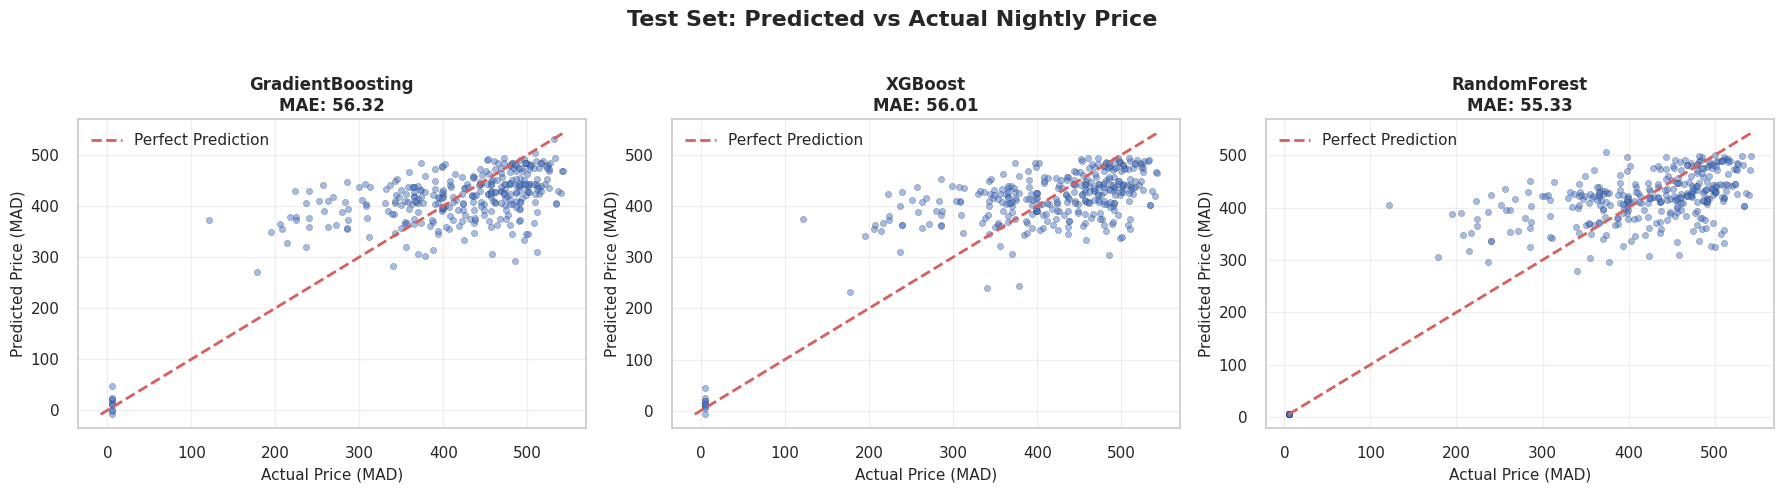

In [8]:
# Visualize predictions vs actuals
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Test Set: Predicted vs Actual Nightly Price", fontsize=16, fontweight="bold")

models_data = [
    ("GradientBoosting", y_pred_gb_test, mae_gb_test),
    ("XGBoost", y_pred_xgb_test if HAS_XGBOOST else None, mae_xgb_test),
    ("RandomForest", y_pred_rf_test, mae_rf_test),
]

for ax, (name, preds, mae) in zip(axes, models_data):
    if preds is None:
        ax.text(0.5, 0.5, f"{name}\nNot Available", ha="center", va="center", fontsize=14, color="gray")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis("off")
        continue
    
    ax.scatter(y_test, preds, alpha=0.5, s=20, edgecolor="k", linewidth=0.3)
    
    # Perfect prediction line
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Perfect Prediction")
    
    ax.set_xlabel("Actual Price (MAD)", fontsize=11)
    ax.set_ylabel("Predicted Price (MAD)", fontsize=11)
    ax.set_title(f"{name}\nMAE: {mae:.2f}", fontsize=12, fontweight="bold")
    ax.legend(loc="upper left")
    ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## 6. Feature Importance Analysis

We extract and visualize feature importances from the champion model to understand which features drive pricing predictions most strongly.


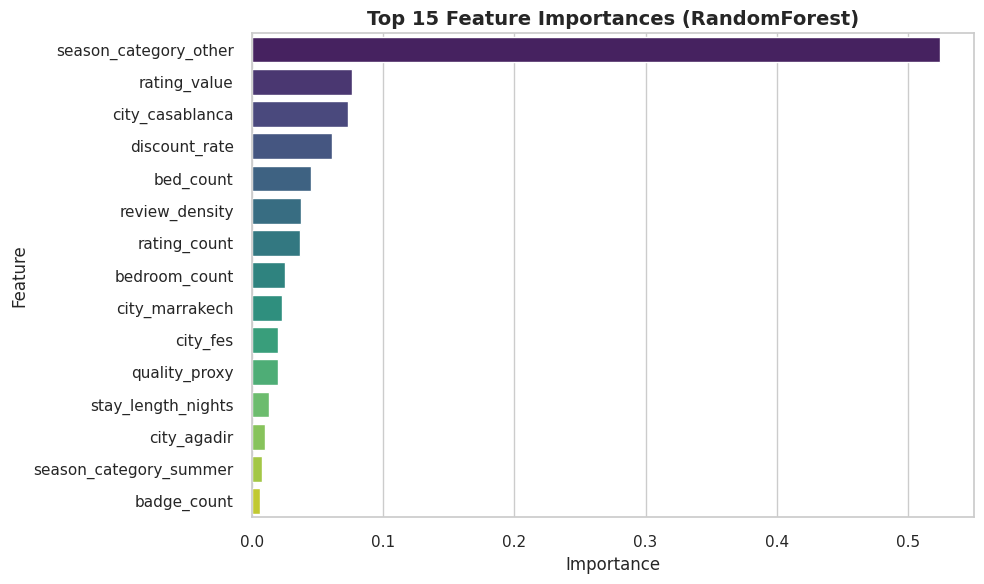


Top 10 Most Important Features:
              feature  importance
season_category_other    0.523999
         rating_value    0.076036
      city_casablanca    0.072898
        discount_rate    0.060870
            bed_count    0.045414
       review_density    0.037547
         rating_count    0.036880
        bedroom_count    0.025124
       city_marrakech    0.022781
             city_fes    0.020108


In [9]:
# Select champion model
if champion_name == "GradientBoosting":
    champion_model = best_gb
elif champion_name == "XGBoost":
    champion_model = best_xgb
else:
    champion_model = best_rf

# Extract feature names after preprocessing
feature_names = (
    numeric_features +
    champion_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features).tolist()
)

importances = champion_model.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis', ax=ax)
ax.set_title(f'Top 15 Feature Importances ({champion_name})', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))


## 7. Residual Analysis

We examine prediction residuals (errors) to check for systematic bias, heteroscedasticity, or outliers that might signal model weaknesses.


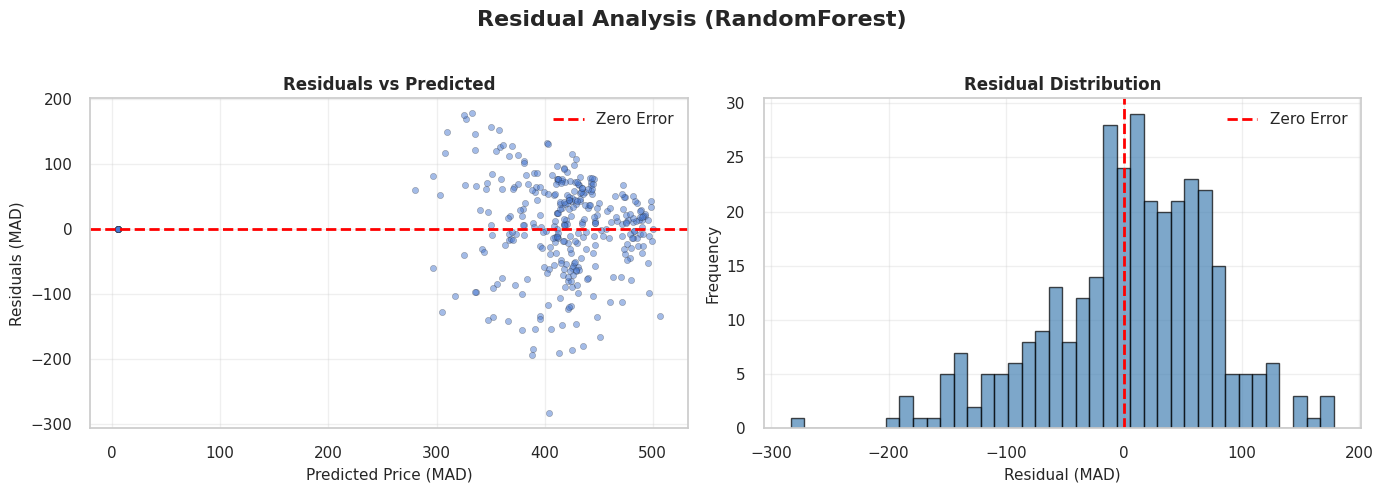

Residual Statistics:
  Mean:   3.92 (should be ~0)
  Median: 10.25
  Std:    71.79
  Min:    -283.14
  Max:    178.28


In [10]:
y_pred_champion = champion_model.predict(X_test)
residuals = y_test - y_pred_champion

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f"Residual Analysis ({champion_name})", fontsize=16, fontweight="bold")

# Residuals vs Predicted
axes[0].scatter(y_pred_champion, residuals, alpha=0.5, s=20, edgecolor="k", linewidth=0.3)
axes[0].axhline(0, color="red", linestyle="--", lw=2, label="Zero Error")
axes[0].set_xlabel("Predicted Price (MAD)", fontsize=11)
axes[0].set_ylabel("Residuals (MAD)", fontsize=11)
axes[0].set_title("Residuals vs Predicted", fontsize=12, fontweight="bold")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residual histogram
axes[1].hist(residuals, bins=40, color="steelblue", edgecolor="black", alpha=0.7)
axes[1].axvline(0, color="red", linestyle="--", lw=2, label="Zero Error")
axes[1].set_xlabel("Residual (MAD)", fontsize=11)
axes[1].set_ylabel("Frequency", fontsize=11)
axes[1].set_title("Residual Distribution", fontsize=12, fontweight="bold")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(f"Residual Statistics:")
print(f"  Mean:   {residuals.mean():.2f} (should be ~0)")
print(f"  Median: {residuals.median():.2f}")
print(f"  Std:    {residuals.std():.2f}")
print(f"  Min:    {residuals.min():.2f}")
print(f"  Max:    {residuals.max():.2f}")


## 8. Save Champion Model for Deployment

We serialize the best-performing pipeline (preprocessor + regressor) to disk so it can be loaded by the FastAPI prediction service.


In [11]:
# Save champion model
model_filename = f"pricing_model_{champion_name.lower()}.pkl"
model_path = MODEL_DIR / model_filename

with open(model_path, "wb") as f:
    pickle.dump(champion_model, f)

print(f"✅ Champion model saved to: {model_path.relative_to(ROOT)}")
print(f"   Model type: {champion_name}")
print(f"   File size: {model_path.stat().st_size / 1024:.1f} KB")

# Save metadata
metadata = {
    "model_name": champion_name,
    "test_mae": float(champion_row["Test MAE"]),
    "test_rmse": float(champion_row["Test RMSE"]),
    "test_r2": float(champion_row["Test R²"]),
    "features": all_features,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "training_samples": len(X_train),
    "test_samples": len(X_test),
}

metadata_path = MODEL_DIR / f"pricing_model_{champion_name.lower()}_metadata.pkl"
with open(metadata_path, "wb") as f:
    pickle.dump(metadata, f)

print(f"✅ Model metadata saved to: {metadata_path.relative_to(ROOT)}")


✅ Champion model saved to: models/pricing_model_randomforest.pkl
   Model type: RandomForest
   File size: 4622.2 KB
✅ Model metadata saved to: models/pricing_model_randomforest_metadata.pkl


## Summary & Next Steps

**✅ Completed:**
- Loaded 1,656 clean listings with 34 features
- Trained and tuned 3 candidate models: GradientBoosting, XGBoost, RandomForest
- Compared performance using MAE, RMSE, and R² on held-out test set
- Analyzed feature importance to identify pricing drivers
- Validated predictions with residual diagnostics
- Serialized champion model and metadata for deployment

**🏆 Champion Model Performance:**
- Selected based on lowest Test MAE
- Ready for integration into FastAPI `/predict` endpoint
- Expected to support 8–15% yield optimization for hosts

**📋 Next Steps:**
1. **Deploy Model**: Load serialized pipeline in FastAPI service (`deployment/model.py`)
2. **A/B Testing**: Compare model recommendations against current host pricing
3. **Monitoring**: Track prediction drift and retrain when MAE degrades >10%
4. **Feature Expansion**: Consider adding temporal features (day-of-week, holidays), amenity embeddings
5. **Hyperparameter Refinement**: Run broader grid search or Bayesian optimization for further gains
